<a href="https://colab.research.google.com/github/ArceusRay/-/blob/main/%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  卷积网络 Pytorch.

# Convolutional networks.


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import numpy as np

import torch

之前我们使用 Pytorch 框架进行了培训，编写了自己的模块，并在具有少量分辨率相当低的对象的玩具数据集上实现了训练周期。 现在我们将从另一边开始——我们将使用神经网络的现成层实现，并且我们将在中等大小和分辨率的数据上测试模型。

就像之前的任务一样，我们将解决多类分类的问题。 同时，我们将构建一个卷积网络，而不是完全连接的网络，由于其归纳偏差，该网络通常在计算机视觉（CV）任务中效果更好。


Previously we used the Pytorch framework for training, writing our own modules, and implementing a training cycle on a toy dataset with a small number of objects of rather low resolution. Now we will go from the other side - we will use ready-made implementations of layers for a neural network and we will test models on data of moderately large size and resolution.

Just like in the previous task, we will solve the problem of multi-class classification. At the same time, instead of fully connected networks, we will construct a convolutional network, which, due to its inductive bias, usually works better in computer vision (CV) tasks.

这次我们将从加载和预处理训练数据开始。 Pytorch 实现了一组现成的类和函数来处理数据集。 通常，在使用 **Pytorch** 时，数据集表示为 `torch.utils.data.Dataset` 类的后代：

This time we'll start by loading and preprocessing the training data. Pytorch implements a ready-made set of classes and functions for working with data sets. Typically, when working with **Pytorch**, a dataset is represented as a descendant of the `torch.utils.data.Dataset` class:
```python
class DatasetExample(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        
    def __getitem__(self, idx):
        '''
        Возвращает элемент датасета по его индексу
        :param int idx: Номер элемента в датасете
        :returns: Объект из выборки с порядковым номером idx
        '''
        ...
        
    def __len__(self):
        '''
        Опциональный метод, возвращает число элементов в датасете
        '''
        ...
```

**Pytorch** 中图像的基本工作被分成一个单独的模块`torchvision`。 该库允许您：
* 加载并使用流行的计算机视觉数据集
* 将转换应用于`PIL`、`numpy.ndarray`和`torch.Tensor`格式的图像
* 使用 CV 特定的块和损失函数
* 使用现成的CV模型架构（包括预训练模型）

`torchvision` 库中的所有数据集均继承自 `torch.utils.data.Dataset`。 此外，几乎所有数据集都有类构造函数参数`transforms`和`target_transform`，它们分别指定要应用于网络输入（通常是图像）和目标（通常是类标签）的转换。 转型的关键用例包括：
* 将图像从一种格式转换为另一种格式。 例如，数据集通常以`PIL`格式存储和返回图像，而图像必须以`torch.Tensor`的形式传输到神经网络
* 图像的标准化和增强
* 类标签的规范化，即将它们及其字符串表示形式转换为数字形式

`torchvision` 库包含大量[现成的转换](https://pytorch.org/vision/stable/transforms.html)。

要使用`CIFAR10`数据集，我们需要以下数据：
* `torchvision.transforms.ToTensor` - 将`PIL`图像转换为`torch.Tensor`
* `torchvision.transforms.Normalize` - `torch.Tensor` 格式的图像标准化
* `torchvision.transforms.Compose` - 一个允许您将多个连续转换组合为一个的类

Basic work with images in **Pytorch** is separated into a separate module `torchvision`. This library allows you to:
* Load and work with popular computer vision datasets
* Apply transformations to images in `PIL`, `numpy.ndarray` and `torch.Tensor` formats
* Use CV-specific blocks and loss functions
* Use ready-made CV model architectures (including pre-trained models)

All datasets in the `torchvision` library are inherited from `torch.utils.data.Dataset`. Also, almost all datasets have class constructor arguments `transforms` and `target_transform`, which specify transformations to be applied to network inputs (usually images) and targets (usually class labels), respectively. Key use cases for transformations include:
* Convert images from one format to another. For example, datasets usually store and return images in `PIL` format, while images must be transferred to the neural network in the form of `torch.Tensor`
* Normalization and augmentation of images
* Normalization of class labels, that is, converting them and their string representation into a numerical one

The `torchvision` library contains a large set of [ready-made transformations](https://pytorch.org/vision/stable/transforms.html).

To work with the `CIFAR10` dataset we will need the following of them:
* `torchvision.transforms.ToTensor` - converting a `PIL` image to `torch.Tensor`
* `torchvision.transforms.Normalize` - image normalization in `torch.Tensor` format
* `torchvision.transforms.Compose` - a class that allows you to combine several successive transformations into one

In [ ]:
import torchvision

让我们加载`CIFAR10`数据集并查看其内容：

Let's load the `CIFAR10` dataset and look at its contents:

In [ ]:
# 注意函数参数：
# train负责应该使用哪个split，即训练集还是测试集
ds_train_no_transform = torchvision.datasets.CIFAR10(
    root='./', train=True, transform=None, download=True
)

Files already downloaded and verified


Описание датасета:
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train

Объект датасета — PIL изображение и метка: (<PIL.Image.Image image mode=RGB size=32x32 at 0x1AD77471C10>, 6)



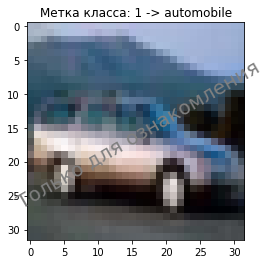

In [ ]:
print(f'Описание датасета:\n{ds_train_no_transform}\n')
print(f'Объект датасета — PIL изображение и метка: {ds_train_no_transform[0]}\n')

image, label = ds_train_no_transform[4]

plt.imshow(image)

plt.text(
    16.0, 16.0, 'Только для ознакомления',
    fontsize=20, color='gray', alpha=1.0,
    ha='center', va='center', rotation='30'
)

plt.title(f'Метка класса: {label} -> {ds_train_no_transform.classes[label]}')
plt.show()

让我们为图像创建一个`transform`，它将其从`PIL`格式转换为`torch.Tensor`，然后对其进行标准化：

Let's create a `transform` for the image, which will convert it from `PIL` format to `torch.Tensor`, and then normalize it:

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # Используем среднее и стандартное отклонение, посчитанные для датасета CIFAR10
    # https://github.com/kuangliu/pytorch-cifar/issues/16
    torchvision.transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

将变换应用于图像：

Apply the transformation to the image:

Тип изображения до трансформации: <class 'PIL.Image.Image'>. Размер: (32, 32). Тип изображения: RGB
Тип изображения после трансформации: <class 'torch.Tensor'>. Размер: torch.Size([3, 32, 32])


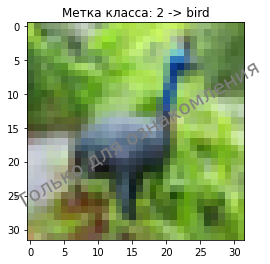

In [ ]:
image, label = ds_train_no_transform[6]
print(f'Тип изображения до трансформации: {type(image)}. Размер: {image.size}. Тип изображения: {image.mode}')

image_tensor = transform(image)
print(f'Тип изображения после трансформации: {type(image_tensor)}. Размер: {image_tensor.shape}')

plt.imshow(image)

plt.text(
    16.0, 16.0, 'Только для ознакомления',
    fontsize=20, color='gray', alpha=1.0,
    ha='center', va='center', rotation='30'
)

plt.title(f'Метка класса: {label} -> {ds_train_no_transform.classes[label]}')
plt.show()

使用 `CIFAR10` 数据集的训练和测试拆分创建数据集。 不要忘记传递一个转换函数。

Create datasets with a training and test split of the `CIFAR10` dataset. Don't forget to pass a function for the transformation.

In [ ]:
ds_train = torchvision.datasets.CIFAR10(root='./', train=True, transform=transform, download=False)
ds_test = torchvision.datasets.CIFAR10(root='./', train=False, transform=transform, download=False)

In [ ]:
ds_train, ds_test

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ))

[链接](https://)为了方便起见，我们将立即定义逆变换，从张量中生成可以正确显示的 PIL 图像：

[Link text](https://)For convenience, we will immediately define the inverse transformation, which from the tensor makes a PIL image that can be displayed correctly:

In [ ]:
tmean, tstd = transform.transforms[1].mean, transform.transforms[1].std
tmean, tstd = np.array(tmean), np.array(tstd)

inverse_transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean=-tmean / tstd,
        std=1.0 / tstd
    ),
    torchvision.transforms.ToPILImage()
])

让我们看一下训练集和测试集中的一些图像：

Let's look at a few images from the training and test sets:

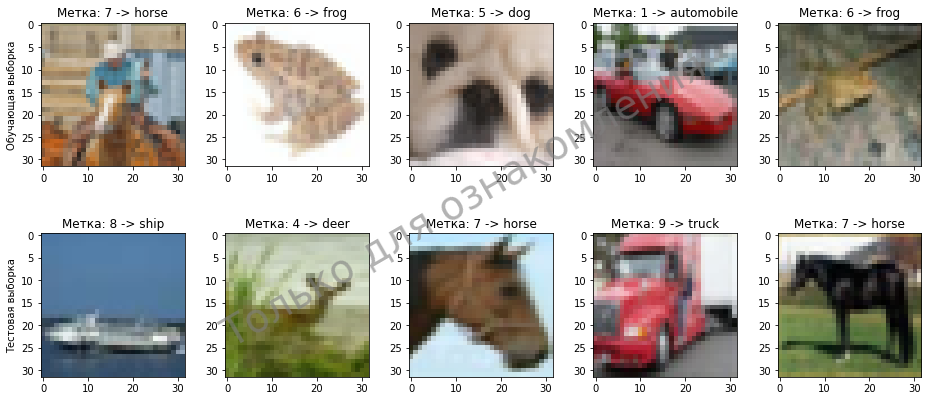

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(13, 6))

for idx, ds in enumerate((ds_train, ds_test)):
    for jdx, kdx in enumerate(np.random.randint(0, len(ds), size=5)):
        image, label = ds[kdx]
        axes[idx, jdx].imshow(inverse_transform(image))
        axes[idx, jdx].set_title(f'Метка: {label} -> {ds.classes[label]}')

axes[0, 0].set_ylabel('Обучающая выборка')
axes[1, 0].set_ylabel('Тестовая выборка')

fig.text(
    0.5, 0.5, 'Только для ознакомления',
    fontsize=40, color='gray', alpha=0.6,
    ha='center', va='center', rotation='30'
)

fig.tight_layout()
plt.show()

在上一个任务中，我们使用了一个优化器，需要计算整个样本的梯度。 然而，在实践中，通常使用随机优化方法，该方法使用从训练集中采样的批量对象。 尽管可以手动完成数据集中的对象混合和批处理，但 **Pytorch** 允许您更有效地执行这些操作。 为此，他们通常使用一个类将数据集转换为批处理生成器`torch.utils.data.DataLoader`。 该包装器允许将对象合并为一批，即合并每个对象中相应的张量（例如图像和相应的标签）。

数据加载器的基本参数：
- `batch_size` — 每次访问实例时采样的子样本大小
- `shuffle` — 是否随机播放选择
- `num_workers` 是决定批量生成器性能的关键参数。 让我们更详细地描述该参数的影响。 在生成下一批的过程中，数据加载器必须执行几个缓慢的过程：从相应的数据集中请求对象，这通常包括从硬盘读取（因为大数据集不适合 RAM）、对所有图像应用转换并连接将单个对象转化为一个张量。 事实证明，计算通过网络的前向传递的速度通常比生成下一批的速度要快，这会导致程序效率明显低下。 在这种情况下，需要增加并行进程的数量，每个进程都会生成另一批数据。 在实践中，选择正确的工人数量可以使速度成倍提高（通常，搜索从 3-4$ 工人开始）

In the previous task, we used an optimizer that required calculating the gradient over the entire sample. However, in practice, stochastic optimization methods are usually used, which use batches of objects sampled from the training set. Although mixing and batching objects from a dataset can be done manually, **Pytorch** allows you to do these operations much more efficiently. To do this, they usually use a class that converts the dataset into a batch generator `torch.utils.data.DataLoader`. This wrapper allows you to combine objects into one batch, that is, combine the corresponding tensors in each object (for example, images and corresponding labels).

Basic parameters of the dataloader:
- `batch_size` — subsample size sampled each time the instance is accessed
- `shuffle` — shuffle the selection or not
- `num_workers` is a key parameter that determines the performance of the batch generator. Let us describe the influence of this parameter in more detail. In the process of generating the next batch, the dataloader must perform several slow procedures: requesting objects from the corresponding dataset, which often includes reading from the hard drive (since large datasets do not fit in RAM), applying transformations to all images and concatenating individual objects into one tensor. It often turns out that calculating a forward pass through the network occurs faster than the next batch is generated, which leads to a significantly inefficient program. In this case, it is necessary to increase the number of parallel processes, each of which generates another batch of data. In practice, choosing the right number of workers can give a multiple increase in speed (usually, the search starts with $3-4$ workers)

为 CIFAR10 训练和测试样本创建数据加载器。 请注意，每次通过样本时都必须对训练集进行打乱，但测试集则不能。

Create dataloaders for CIFAR10 training and test samples. Note that the training set must be shuffled with each pass through the sample, but the test set must not.

In [ ]:
batch_size = 128

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, num_workers=1, shuffle=False, pin_memory=True)

让我们看看数据加载器中的批次：

Let's look at the batch from the dataloader:

In [ ]:
images, labels = next(iter(dl_train))
print(images.shape, labels.shape)

torch.Size([128, 3, 32, 32]) torch.Size([128])


我们实现了一个类似 VGG 的卷积网络。 该网络将由三个主要块组成：
1. 卷积特征提取器
     * 该层序列将具有 $3$ 通道的图像作为输入
     * 层的顺序由`cfg`配置列表指定：
         - 数字表示下一个卷积的输出通道数。 使用内核 $3\times3$ 和填充 $1$ 的卷积
         - “M”表示最大池化层。 每个这样的层应将图像的空间维度减少 $2$ 倍
2. 自适应平均池化层
     - 使用输出空间分辨率$2\times2$
3. 全连接`head`分类器，具有 $2$ 隐藏层，维度为 $128$

* 到处使用`ReLU`作为激活函数
* 根据`use_batchnorm`标志，在每个卷积层后面添加一个batchnorm
* 在全连接层之间，添加“Dropout”层，其值为 $p = \text{dropout_p}$
* 仅使用 `torch.nn` 中的现成模块。 要将层组合成块，请使用“torch.nn.Sequential”

We implement a convolutional VGG-like network. The network will consist of three main blocks:
1. Convolutional feature extractor
     * This sequence of layers takes as input an image with $3$ channels
     * The sequence of layers is specified by the `cfg` configuration list:
         - The number means the number of output channels of the next convolution. Use convolutions with kernel $3\times3$ and padding $1$
         - `"M"` means Max Pooling layer. Each such layer should reduce the spatial dimensions of the image by $2$ times
2. Adaptive Average Pooling Layer
     - Use output spatial resolution $2\times2$
3. Fully connected “head” classifier with $2$ hidden layers of $128$ dimension

* Use `ReLU` as activation function everywhere
* Depending on the `use_batchnorm` flag, add a batchnorm after each convolutional layer
* Between fully connected layers, add `Dropout` layers with the value $p = \text{dropout_p}$
* Use only ready-made modules from `torch.nn`. To combine layers into blocks, use `torch.nn.Sequential`

In [ ]:
class ConvNet(torch.nn.Module):
    cfg = [32, "M", 64, 64, "M", 128, 128, "M"]

    def __init__(self, n_classes=10, use_batchnorm=False, dropout_p=0.0):
        '''
        :param int n_classes: Число выходных признаков
        :param bool use_batchnorm: Использовать ли батчнорм между свёрточными слоями
        :param float dropout_p: Вероятность обнуления активации слоем Dropout
        '''
        super().__init__()

        self.n_classes = n_classes

        features = [torch.nn.Conv2d(3, self.cfg[0],
                                    kernel_size=3, padding=1,
                                    padding_mode='reflect'),
                    torch.nn.ReLU()] if not use_batchnorm else [torch.nn.Conv2d(3, self.cfg[0],
                                                                                kernel_size=3, padding=1,
                                                                                padding_mode='reflect'),
                                                                torch.nn.ReLU(),
                                                                torch.nn.BatchNorm2d(self.cfg[0])]
        for pr_l, l in zip(self.cfg[:-1], self.cfg[1:]):
            if l == 'M':
                features.append(torch.nn.MaxPool2d(kernel_size=2))
            else:
                features.append(torch.nn.Conv2d(l // 2 if pr_l == "M" else pr_l, l,
                                    kernel_size=3, padding=1,
                                    padding_mode='reflect'))
                features.append(torch.nn.ReLU())
                if use_batchnorm:
                    features.append(torch.nn.BatchNorm2d(l))


        self.features = torch.nn.Sequential(*features)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = torch.nn.Sequential(*[
            torch.nn.Linear(512, 128, bias=True), torch.nn.ReLU(), torch.nn.Dropout(p=dropout_p),
#             torch.nn.Linear(128, 128, bias=True), torch.nn.ReLU(), torch.nn.Dropout(p=dropout_p),
            torch.nn.Linear(128, 128, bias=True), torch.nn.ReLU(), torch.nn.Dropout(p=dropout_p),
            torch.nn.Linear(128, n_classes, bias=True)
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        feat = self.features(x)
        pooled = self.avgpool(feat)
        flattened = torch.flatten(pooled, start_dim=1)
        return self.classifier(flattened)

验证网络实施是否通过了最低限度的测试：

Verify that your network implementation passes the minimum tests:

In [ ]:
assert sum(buffer.numel() for buffer in ConvNet(use_batchnorm=True).buffers()) == 837
assert sum(param.numel() for param in ConvNet(use_batchnorm=True).parameters()) == 362058
assert sum(param.numel() for param in ConvNet(use_batchnorm=False).parameters()) == 361226

sample_image = torch.randn([11, 3, 32, 32])
sample_model = ConvNet(use_batchnorm=False, dropout_p=0.5)
assert torch.all(torch.ne(sample_model.train()(sample_image), sample_model.eval()(sample_image)))

assert list(ConvNet().features(sample_image).shape) == [11, 128, 4, 4]
assert list(ConvNet().avgpool(ConvNet().features(sample_image)).shape) == [11, 128, 2, 2]
assert list(ConvNet()(sample_image).shape) == [11, 10]

作为损失函数，我们将像上一个任务一样使用交叉熵，但这次它是现成的实现。 作为优化器，我们以机器学习中的基本优化器——SGD为例：

As a loss function, we will use, as in the previous task, crossentropy, but this time its ready-made implementation. As an optimizer, let's take the basic optimizer in machine learning - SGD:

In [ ]:
conv_network = ConvNet()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_network.parameters(), lr=2e-2)

让我们定义一个用于计算的设备并传输模型：

Let's define a device for calculations and transfer the model:

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 0)

print(type(device), device)

<class 'torch.device'> cuda:0


In [ ]:
conv_network.to(device)

ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (4): ReLU()
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(2, 2))
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True

现在剩下的就是实现神经网络的训练周期。 由于此任务将使用 SGD 优化器，因此无需通过闭包函数来实现优化步骤。 以任何方便的方式实施优化步骤。

Now it remains to implement the training cycle for the neural network. Since this task will use the SGD optimizer, there is no need to implement the optimization step through a closure function. Implement the optimization step in any convenient way.

In [ ]:
import tqdm.notebook as tqdm
from functools import partial

In [ ]:
def training_loop(n_epochs, network, loss_fn, optimizer, dl_train, dl_test, device):
    '''
    :param int n_epochs: Число итераций оптимизации
    :param torch.nn.Module network: Нейронная сеть
    :param Callable loss_fn: Функция потерь
    :param torch.nn.Optimizer optimizer: Оптимизатор
    :param torch.utils.data.DataLoader dl_train: Даталоадер для обучающей выборки
    :param torch.utils.data.DataLoader dl_test: Даталоадер для тестовой выборки
    :param torch.Device device: Устройство на котором будут происходить вычисления
    :returns: Списки значений функции потерь и точности на обучающей и тестовой выборках после каждой итерации
    '''
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    for epoch in (pbar := tqdm.tqdm(range(n_epochs), total=n_epochs, leave=False)):

        network.train()

        # Итерация обучения сети
        for images, labels in tqdm.tqdm(dl_train, total=len(dl_train), leave=False):
            # Реализуйте шаг оптимизации. Использовать функцию-замыкание для передачи в оптимизатор не обязательно
            # Можете вынести подсчёт градиентов из функции в сам цикл
            def closure(images, labels):
                '''
                Функция-замыкания для подсчёта градиентов функции потерь по обучающей выборке:
                    1. Отчистка текущих градиентов
                    2. Выполнение прямого прохода по сети в вычисление функции потерь
                    3. Вычисление градиентов функции потерь

                Для передачи аргументов в функцию-замыкание можно использовать функцию partial
                :returns: Значение функции потерь
                '''

                optimizer.zero_grad()
                logits = network(images)
                loss = loss_fn(logits, labels)
                return loss

            # Шаг оптимизации

            loss = closure(images.to(device), labels.to(device))
            loss.backward()
            optimizer.step()

        # Оцениваем качество модели каждые 3 итерации
        if epoch % 3 == 0 or epoch == n_epochs - 1:
            # Переводим сеть в инференс режим

            network.eval()
            cur_train_losses = []
            cur_train_accuracy = []
            cur_eval_losses = []
            cur_eval_accuracy = []

            # При тестировании сети нет необходимости считать градиенты, поэтому можно отключить автоматическое дифференцирование
            #   для ускорения операций
            with torch.no_grad():
                # Вычисление качества и функции потерь на обучающей выборке

                for images, labels in tqdm.tqdm(dl_train, total=len(dl_train), leave=False):
                    logits = network(images.to(device)).cpu()
                    cur_train_losses.append(loss_fn(logits, labels).view(-1, 1))
                    cur_train_accuracy.append((logits.argmax(-1) == labels).float().mean().view(-1, 1))
                train_losses.append(torch.cat(cur_train_losses, dim=0).mean().item())
                train_accuracies.append(torch.cat(cur_train_accuracy, dim=0).float().mean().item())

                # Вычисление качества и функции потерь на тестовой выборке

                for images, labels in tqdm.tqdm(dl_test, total=len(dl_test), leave=False):
                    logits = network(images.to(device)).cpu()
                    cur_eval_losses.append(loss_fn(logits, labels).view(-1, 1))
                    cur_eval_accuracy.append((logits.argmax(-1) == labels).float().mean().view(-1, 1))
                test_losses.append(torch.cat(cur_eval_losses, dim=0).mean().item())
                test_accuracies.append(torch.cat(cur_eval_accuracy, dim=0).float().mean().item())

            pbar.set_description(
                'Loss (Train/Test): {0:.3f}/{1:.3f}. Accuracy, % (Train/Test): {2:.2f}/{3:.2f}\n'.format(
                    train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
                )
            )

    return train_losses, test_losses, train_accuracies, test_accuracies

最后，训练模型的一切准备就绪：

Finally, everything is ready to train the model:

In [ ]:
n_epochs = 100
train_losses, test_losses, train_accs, test_accs = training_loop(
    n_epochs=n_epochs, network=conv_network, loss_fn=loss_fn,
    optimizer=optimizer, dl_train=dl_train, dl_test=dl_test, device=device
)

**1.** 让我们构建一个用于训练和测试的质量图：

Let’s build a quality graph for training and testing:

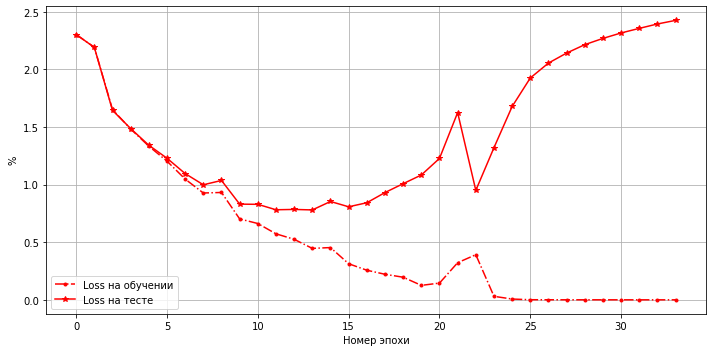

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_losses, label="Loss на обучении", color='red', marker='.', linestyle='-.')
ax.plot(test_losses, label="Loss на тесте", color='red', marker='*')

ax.set_xlabel("Номер эпохи")
ax.set_ylabel("$\%$")

ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

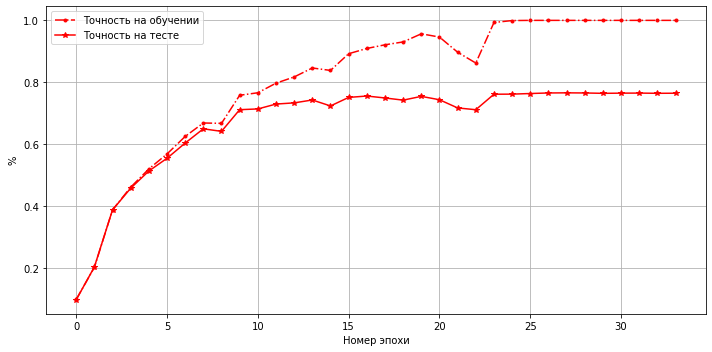

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_accs, label="Точность на обучении", color='red', marker='.', linestyle='-.')
ax.plot(test_accs, label="Точность на тесте", color='red', marker='*')

ax.set_xlabel("Номер эпохи")
ax.set_ylabel("$\%$")

ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

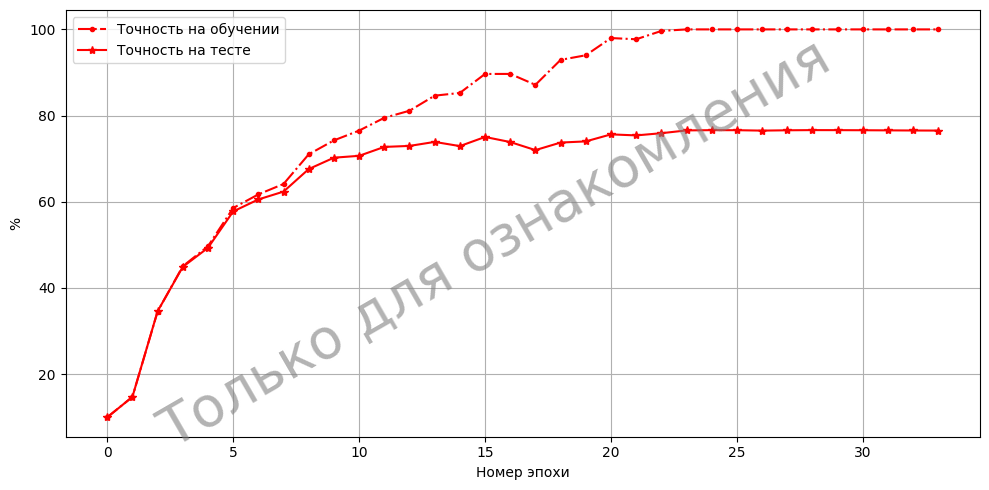

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_accs, label="Точность на обучении", color='red', marker='.', linestyle='-.')
ax.plot(test_accs, label="Точность на тесте", color='red', marker='*')

ax.set_xlabel("Номер эпохи")
ax.set_ylabel("$\%$")

ax.grid(True)
ax.legend()

fig.text(
    0.5, 0.5, 'Только для ознакомления',
    fontsize=40, color='gray', alpha=0.6,
    ha='center', va='center', rotation='30'
)

fig.tight_layout()
plt.show()

**2.** 现在，为了进行比较，使用batchnorm、dropout（使用$p=0.5$）以及两者来训练模型。 不要忘记保存所有指标，以便比较图表上考虑的所有 $4$ 模型：

Now, for comparison, train models with batchnorm, dropout (use $p=0.5$) and both. Don’t forget to save all the metrics so that you can then compare all the $4$ models considered on the chart:

In [ ]:
conv_network = ConvNet(use_batchnorm=False, dropout_p=0.5).to(device)
optimizer = torch.optim.SGD(conv_network.parameters(), lr=2e-2)

train_losses_dp, test_losses_dp, train_accs_dp, test_accs_dp = training_loop(
    n_epochs=n_epochs, network=conv_network, loss_fn=loss_fn,
    optimizer=optimizer, dl_train=dl_train, dl_test=dl_test, device=device
)

conv_network = ConvNet(use_batchnorm=True, dropout_p=0.0).to(device)
optimizer = torch.optim.SGD(conv_network.parameters(), lr=2e-2)

train_losses_bn, test_losses_bn, train_accs_bn, test_accs_bn = training_loop(
    n_epochs=n_epochs, network=conv_network, loss_fn=loss_fn,
    optimizer=optimizer, dl_train=dl_train, dl_test=dl_test, device=device
)

conv_network = ConvNet(use_batchnorm=True, dropout_p=0.5).to(device)
optimizer = torch.optim.SGD(conv_network.parameters(), lr=2e-2)

train_losses_bn_dp, test_losses_bn_dp, train_accs_bn_dp, test_accs_bn_dp = training_loop(
    n_epochs=n_epochs, network=conv_network, loss_fn=loss_fn,
    optimizer=optimizer, dl_train=dl_train, dl_test=dl_test, device=device
)

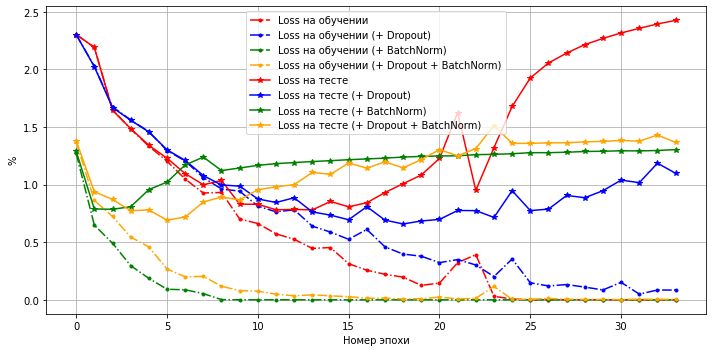

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_losses, label="Loss на обучении", color='red', marker='.', linestyle='-.')
ax.plot(train_losses_dp, label="Loss на обучении (+ Dropout)", color='blue', marker='.', linestyle='-.')
ax.plot(train_losses_bn, label="Loss на обучении (+ BatchNorm)", color='green', marker='.', linestyle='-.')
ax.plot(train_losses_bn_dp, label="Loss на обучении (+ Dropout + BatchNorm)", color='orange', marker='.', linestyle='-.')

ax.plot(test_losses, label="Loss на тесте", color='red', marker='*')
ax.plot(test_losses_dp, label="Loss на тесте (+ Dropout)", color='blue', marker='*')
ax.plot(test_losses_bn, label="Loss на тесте (+ BatchNorm)", color='green', marker='*')
ax.plot(test_losses_bn_dp, label="Loss на тесте (+ Dropout + BatchNorm)", color='orange', marker='*')

ax.set_xlabel("Номер эпохи")
ax.set_ylabel("$\%$")

ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

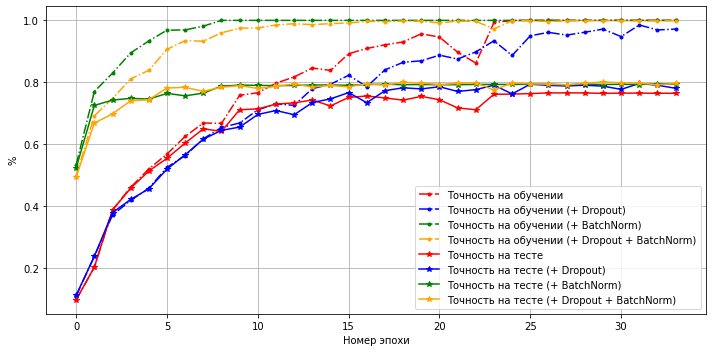

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_accs, label="Точность на обучении", color='red', marker='.', linestyle='-.')
ax.plot(train_accs_dp, label="Точность на обучении (+ Dropout)", color='blue', marker='.', linestyle='-.')
ax.plot(train_accs_bn, label="Точность на обучении (+ BatchNorm)", color='green', marker='.', linestyle='-.')
ax.plot(train_accs_bn_dp, label="Точность на обучении (+ Dropout + BatchNorm)", color='orange', marker='.', linestyle='-.')

ax.plot(test_accs, label="Точность на тесте", color='red', marker='*')
ax.plot(test_accs_dp, label="Точность на тесте (+ Dropout)", color='blue', marker='*')
ax.plot(test_accs_bn, label="Точность на тесте (+ BatchNorm)", color='green', marker='*')
ax.plot(test_accs_bn_dp, label="Точность на тесте (+ Dropout + BatchNorm)", color='orange', marker='*')

ax.set_xlabel("Номер эпохи")
ax.set_ylabel("$\%$")

ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

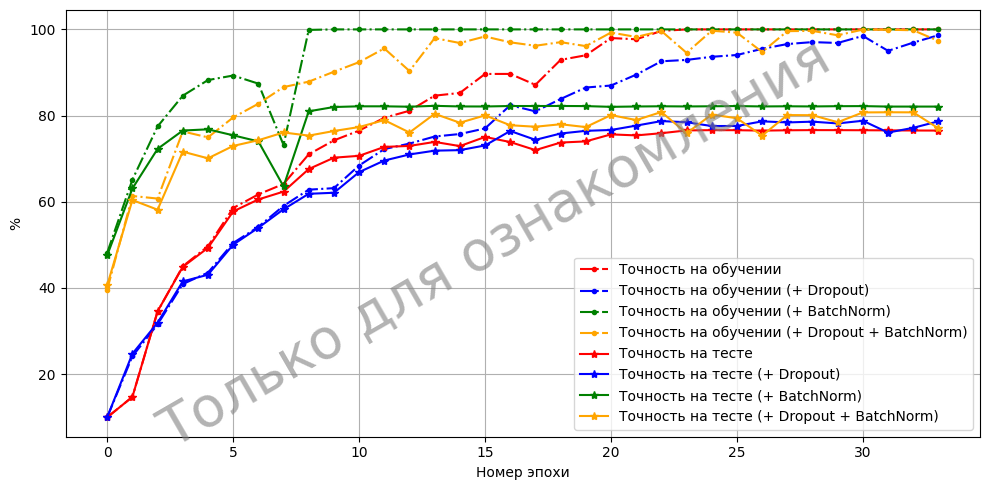

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_accs, label="Точность на обучении", color='red', marker='.', linestyle='-.')
ax.plot(train_accs_dp, label="Точность на обучении (+ Dropout)", color='blue', marker='.', linestyle='-.')
ax.plot(train_accs_bn, label="Точность на обучении (+ BatchNorm)", color='green', marker='.', linestyle='-.')
ax.plot(train_accs_bn_dp, label="Точность на обучении (+ Dropout + BatchNorm)", color='orange', marker='.', linestyle='-.')

ax.plot(test_accs, label="Точность на тесте", color='red', marker='*')
ax.plot(test_accs_dp, label="Точность на тесте (+ Dropout)", color='blue', marker='*')
ax.plot(test_accs_bn, label="Точность на тесте (+ BatchNorm)", color='green', marker='*')
ax.plot(test_accs_bn_dp, label="Точность на тесте (+ Dropout + BatchNorm)", color='orange', marker='*')

ax.set_xlabel("Номер эпохи")
ax.set_ylabel("$\%$")

ax.grid(True)
ax.legend()

fig.text(
    0.5, 0.5, 'Только для ознакомления',
    fontsize=40, color='gray', alpha=0.6,
    ha='center', va='center', rotation='30'
)

fig.tight_layout()
plt.show()

1. 哪个网络表现最好？
2. 训练和测试过程中，batchnorm 和 dropout 对最终质量有何影响？
3. 这些修改如何影响网络训练的收敛速度？

__答案：__

1. 使用批量归一化的网络表现最好，因为它在测试中具有最好的质量和更好的收敛性（就损失而言）。 在测试中，损失的表现比其他损失要稳定得多。
2. Dropout和batchnorm提高了测试的最终质量。 在训练中，dropout 会恶化模型的质量（因为 dropout 本质上是一种正则化，它会阻止模型重新训练并允许您提高网络的泛化能力）。 由于更好的泛化能力，测试的质量提高了。 训练上的 Batchnorm 给出了相同的最终质量，因为虽然它是一种正则化，但它对模型的正则化不够强，这就是为什么它能够记住整个训练样本。 在测试中，批量归一化提高了质量，因为它解决了“dying relu”问题，并且出于同样的原因，它允许网络更快地收敛。
3.批量归一化通过限制网络层之间输出值的传播，使网络收敛得更快，让梯度更好地流经网络，同时也解决了“梯度消失”的问题，使网络不再依赖于权重的初始化。 当使用批量归一化时，各层之间的依赖性变得“更少”，这使得整个网络能够更快地学习。

1. Which network performed best?
2. How do batch norms and dropouts affect the final quality during training and testing?
3. How do these modifications affect the convergence rate of network training?

__Answers:__

1. The network with the batch norm performed best because it has the best quality in the test and better convergence (in terms of loss). On the test, the loss behaves much more stable than the others.
2. Dropout and batchnorm improve the final quality of the test. On the train, dropout worsens the quality of the model (due to the fact that dropout is a regularization in its essence, which prevents the model from retraining and allows you to increase the generalizing ability of the network). The quality of the test increases due to better generalization ability. Batchnorm on train gives the same final quality, because, although it is a kind of regularization, it does not regularize the model strongly enough, which is why it is able to remember the entire train sample. On the test, the batch norm gives an increase in quality due to the fact that it solves the “dying relu” problem and for the same reasons that it allows the network to converge faster.
3. The batch norm allows the network to converge much faster by limiting the spread of output values between network layers, allowing gradients to flow better through the network, also solving the problem of “vanishing gradients” and freeing the network from depending on the initialization of weights. When using the batch norm, layers become “less dependent” on each other, which allows the entire network to learn faster.

一旦模型经过训练，通常需要存储其权重。 **Pytorch** 提供了一个单独的接口，用于保存和稍后加载模型权重。 首先，可以通过`torch.nn.Module`类的`state_dict`方法获取恢复模型状态所需的信息。 默认情况下，此方法返回包含所有**非空参数和模型缓冲区**的字典。 反向方法`load_state_dict`允许您从字典设置参数和缓冲区的值。 其次，要将权重保存到磁盘然后从磁盘加载它们，请使用`torch.save`和`torch.load`方法。

Once a model has been trained, its weights typically need to be stored. **Pytorch** provides a separate interface for saving and later loading model weights. First, the information needed to restore the state of the model can be obtained through the `state_dict` method of the `torch.nn.Module` class. By default, this method returns a dictionary with all **non-null parameters and model buffers**. The reverse method `load_state_dict` allows you to set the values of parameters and buffers from a dictionary. Secondly, to save weights to disk and then load them from disk, use the `torch.save` and `torch.load` methods.

让我们用一个例子来看看这个过程：

Let's look at this procedure using an example:

In [ ]:
state_dict = conv_network.state_dict()
print(state_dict)

OrderedDict([('features.0.weight', tensor([[[[ 3.4828e-02, -4.7479e-01,  9.3834e-03],
          [ 3.6589e-01, -4.2755e-01,  4.4764e-01],
          [ 8.5713e-03, -3.3913e-01,  1.6024e-01]],

         [[ 2.9977e-01, -2.7419e-01,  2.0637e-01],
          [ 4.7025e-01, -4.4318e-01,  4.6082e-01],
          [-7.3205e-03, -3.7873e-01,  6.2348e-02]],

         [[ 1.8526e-01, -4.6038e-01,  3.3116e-02],
          [ 2.9747e-01, -4.6550e-01,  3.7004e-01],
          [ 7.0533e-02, -3.1694e-01,  2.1076e-01]]],


        [[[-7.0629e-02, -1.4335e-01, -2.7174e-01],
          [ 3.7498e-01,  2.5982e-01, -2.0298e-01],
          [ 1.3961e-01,  3.3395e-01, -3.3213e-02]],

         [[-8.6669e-02, -3.4243e-01, -2.5628e-02],
          [ 8.2833e-02,  1.1409e-01, -3.4102e-01],
          [ 1.2921e-01,  1.5849e-01,  1.1271e-01]],

         [[ 4.2368e-02, -2.3527e-01, -8.2467e-02],
          [ 3.1603e-01, -2.7820e-04, -1.2992e-01],
          [-1.5006e-01,  1.4887e-01, -1.8877e-01]]],


        [[[ 3.7664e-01,  1.5292

In [ ]:
torch.save(state_dict, 'conv_weights.pt')

In [ ]:
import os
os.listdir()

['.ipynb_checkpoints',
 'cifar-10-batches-py',
 'cifar-10-python.tar.gz',
 'conv_weights.pt',
 'conv_weights_pretrained.pt',
 'Homework_1.2._Convolutional_Networks.ipynb']

请注意，在 **Google Colab** 中工作时，保存的文件仅在相应的 Jupyter Notebook 运行时才会存在。 当您重新启动时，这些数据将被清除。 要解决此问题，可以将scales保存到您的个人 **Google Drive**，首先使用以下命令安装它：

Note that when working in **Google Colab**, the saved files will only exist while the corresponding Jupyter Notebook is running. When you reboot, this data will be cleared. To solve this problem, you can save the scales to your personal **Google Drive**, having first mounted it with the following command:

```python
from google.colab import drive
drive.mount('/content/drive')
```


现在让我们将权重加载到“干净”模型中：

Now let’s load the weights into the “clean” model:

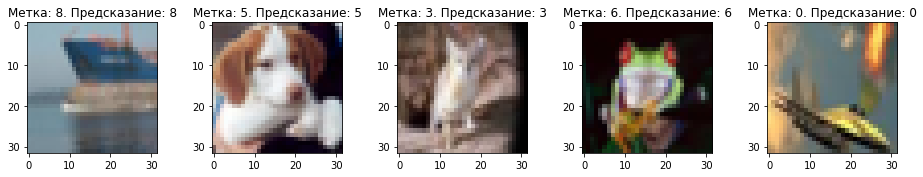

In [ ]:
state_dict = torch.load('conv_weights.pt')

conv_network = ConvNet(use_batchnorm=True, dropout_p=0.5)
conv_network.load_state_dict(state_dict)

images, labels = next(iter(dl_test))

logits = conv_network(images)
predictions = torch.argmax(logits, dim=1)

fig, axes = plt.subplots(1, 5, figsize=(13, 4))
for idx, jdx in enumerate(np.random.randint(0, len(images), size=5)):
    axes[idx].imshow(inverse_transform(images[jdx]))
    axes[idx].set_title(f'Метка: {labels[jdx]}. Предсказание: {predictions[jdx]}')

fig.tight_layout()
plt.show()

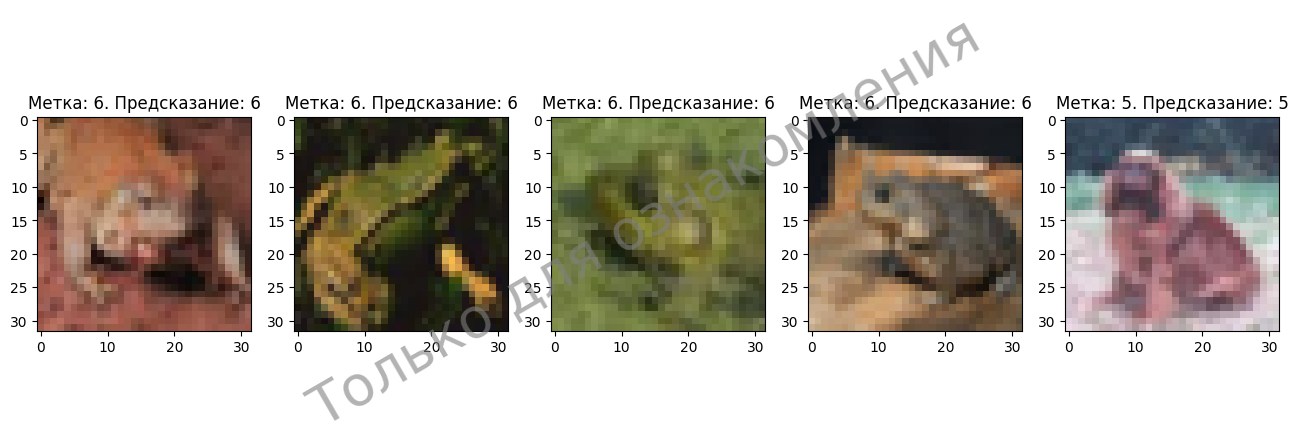

In [ ]:
state_dict = torch.load('conv_weights.pt')

conv_network = ConvNet(use_batchnorm=True, dropout_p=0.5)
conv_network.load_state_dict(state_dict)

images, labels = next(iter(dl_test))

logits = conv_network(images)
predictions = torch.argmax(logits, dim=1)

fig, axes = plt.subplots(1, 5, figsize=(13, 4))
for idx, jdx in enumerate(np.random.randint(0, len(images), size=5)):
    axes[idx].imshow(inverse_transform(images[jdx]))
    axes[idx].set_title(f'Метка: {labels[jdx]}. Предсказание: {predictions[jdx]}')

fig.text(
    0.5, 0.5, 'Только для ознакомления',
    fontsize=40, color='gray', alpha=0.6,
    ha='center', va='center', rotation='30'
)

fig.tight_layout()
plt.show()

请注意，使用`torch.load`（以及使用任何其他 [`pickle`](https://docs.python.org/3/library/pickle.html) 派生函数）加载模型权重是[**不安全操作**](https://pytorch.org/docs/stable/generated/torch.load.html#torch.load)。 在启动过程中，绝对可以执行任何 Python 代码。 因此，仅使用您信任的预先训练的模型。

例如，尝试加载以特殊方式修改的权重：

Note that loading model weights using `torch.load` (as well as using any other [`pickle`](https://docs.python.org/3/library/pickle.html) derived functions) is [**unsafe operation**](https://pytorch.org/docs/stable/generated/torch.load.html#torch.load). During the boot process, absolutely any Python code can potentially be executed. Therefore, use only those pre-trained models that you trust.

For example, try loading weights modified in a special way:

In [ ]:
torch.load('conv_weights_pretrained.pt')

<IPython.core.display.Javascript object>

{'features.0.weight': tensor([[[[ 0.0135, -0.1222, -0.0140],
           [-0.0583, -0.0326, -0.0327],
           [ 0.0364, -0.0228, -0.0144]],
 
          [[-0.1221,  0.0279, -0.0010],
           [ 0.1580,  0.0674, -0.1431],
           [-0.0802,  0.1627,  0.1680]],
 
          [[ 0.0060, -0.1505, -0.1332],
           [-0.1881,  0.0770,  0.1451],
           [ 0.1693,  0.1653, -0.0989]]],
 
 
         [[[-0.1572,  0.0840,  0.1532],
           [-0.1795,  0.1075,  0.0705],
           [ 0.0207, -0.1909,  0.0500]],
 
          [[-0.0900,  0.1825,  0.1370],
           [-0.0408, -0.1705, -0.0184],
           [ 0.1715,  0.0555, -0.0777]],
 
          [[-0.0672,  0.1577,  0.0703],
           [ 0.1888,  0.0674,  0.0603],
           [-0.1027, -0.1378,  0.0135]]],
 
 
         [[[-0.0790, -0.0692, -0.1516],
           [-0.1701,  0.1475,  0.0321],
           [-0.0049,  0.1399,  0.1633]],
 
          [[ 0.0734,  0.0740,  0.1897],
           [ 0.0612, -0.0136, -0.1917],
           [-0.0429,  0.0188, -0